In [1]:
from IPython.display import Image 

This is a follow on from Tutorial 1 where we browsed the Ocean marketplace and downloaded the imagenette dataset. In this tutorial, we will create a model that trains (and overfits) on the small amount of sample data. Once we know that data interface of the input is compatible with our created model (and that the model can successfully overfit on the sample data), then we can be confident enough to send the model to train on the complete dataset.

Now lets inspect the sample data. The data provider should provide this in the same format as the whole dataset. This helps us as data scientists to write scripts that run on both the sample data and the whole dataset. We call this the **interface** of the data. 

In [2]:
from pathlib import Path
imagenette_dir = Path('imagenette2-sample')
print(f"Sub-directories: {sorted(list(imagenette_dir.glob('*')))}")

Sub-directories: [PosixPath('imagenette2-sample/train'), PosixPath('imagenette2-sample/val')]


In [3]:
sorted(list(imagenette_dir.glob('*')))

[PosixPath('imagenette2-sample/train'), PosixPath('imagenette2-sample/val')]

In [4]:
train_dir, val_dir = sorted(list(imagenette_dir.glob('*')))

In [5]:
print(f"Sub-directories in train: {sorted(list(train_dir.glob('*/*')))}")
print(f"Sub-directories in val: {sorted(list(val_dir.glob('*/*')))}")

Sub-directories in train: [PosixPath('imagenette2-sample/train/n01440764/ILSVRC2012_val_00000293.JPEG'), PosixPath('imagenette2-sample/train/n02102040/ILSVRC2012_val_00000665.JPEG')]
Sub-directories in val: [PosixPath('imagenette2-sample/val/n01440764/ILSVRC2012_val_00009111.JPEG'), PosixPath('imagenette2-sample/val/n02102040/ILSVRC2012_val_00004650.JPEG')]


It seems like both the training and validation directorys have folders for each category of image that contain the image files. Of course, we could read the dataset docs if this wasn't immediately clear.

In [6]:
train_images = sorted(list(train_dir.glob('*/*')))
val_images = sorted(list(val_dir.glob('*/*')))
print(f"Number of train images:", len(train_images))
print(f"Number of val images:", len(val_images))

Number of train images: 2
Number of val images: 2


We will use the fast.ai library to train a simple image classifier. 

In [7]:
from fastai.vision.all import *

First we will attempt to train as normal (using both training and validation sets) to ensure that all of the images load without any errors. First we create the dataloaders:

In [8]:
!ls

1-imagenette-classification.ipynb  config.ini
2-coco-keypoints.ipynb		   create-coco-sample.ipynb
3-train-imagenette.ipynb	   imagenette2-sample
4-publish-model-Copy1.ipynb	   imagenette2-sample.tgz
4-publish-model.ipynb		   images
5-run-compute.ipynb		   marketplace-flow.ipynb
coco2017-sample			   publisher-add-trusted-algorithm.ipynb
config-barge.ini


In [13]:
imagenette_dir

Path('imagenette2-sample')

In [19]:
path = Path('imagenette2-sample.tgz')

In [20]:
import xtarfile as tarfile
tar = tarfile.open(path, "r:gz")

In [35]:
from PIL import Image
import io

images = []
for member in tar.getmembers():
    f = tar.extractfile(member)
    if f is not None:
        image_data = f.read()
        image = Image.open(io.BytesIO(image_data))        
        images.append(image)

In [11]:
path = Path()

In [12]:
dls = ImageDataLoaders.from_folder(path, train='train', valid='val', 
    item_tfms=RandomResizedCrop(128, min_scale=0.35), batch_tfms=Normalize.from_stats(*imagenet_stats), bs=2)

TypeError: 'NoneType' object is not iterable

We can visualise the images in the training set as follows:

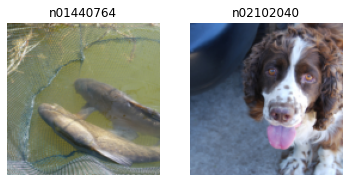

In [9]:
dls.show_batch()

We choose a simple ResNet-34 architecture.

In [10]:
learn = cnn_learner(dls, resnet34, metrics=accuracy, pretrained=False)

And run training for 5 epochs with a learning rate of 0.001.

In [11]:
learn.fit_one_cycle(7, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.626545,32.004219,0.500000,00:00
1,0.338465,16.457916,0.500000,00:01
2,0.230855,17.961416,0.500000,00:01
3,0.263312,22.379690,0.500000,00:01
4,0.286586,25.537163,0.500000,00:01
5,0.737500,20.500233,0.500000,00:01
6,0.639645,5.652335,0.500000,00:01


As you can see, the accuracy is 50% meaning, which is the same as random guessing. We can visualise the results using the following. Note that the results are on the validation images.

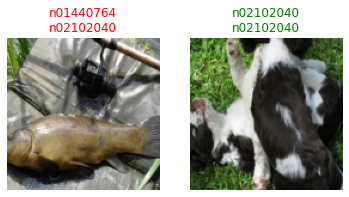

In [12]:
learn.show_results()

The reason for the accuracy is that the size of the training set is not large enough to generalize to the validation set. Thus, while we have confirmed that both the training images and validation images load correctly, we have not confirmed that our selected model trains properly. To ensure, this we will instead use the training set for validation. This is a very simple case for the model since it does not have to learn to generalise and can simply memorise the input data. If the model cannot achieve this, there must be some bug in the code. Let's create new dataloaders for this scenario:

In [13]:
dls_overfit = ImageDataLoaders.from_folder(imagenette_dir, train='train', valid='train', 
    item_tfms=RandomResizedCrop(128, min_scale=0.35), batch_tfms=Normalize.from_stats(*imagenet_stats), bs=2)

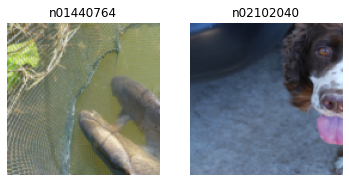

In [14]:
dls_overfit.show_batch()

In [15]:
learn_overfit = cnn_learner(dls_overfit, resnet34, metrics=accuracy, pretrained=False)

In [16]:
learn_overfit.fit_one_cycle(7, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.175914,35.319393,0.500000,00:01
1,2.758166,12.109789,0.500000,00:01
2,2.702485,0.389358,1.000000,00:01
3,2.145204,0.769802,0.500000,00:01
4,1.704967,0.830771,0.500000,00:01
5,1.892232,0.391005,0.500000,00:01
6,1.609352,0.238087,1.000000,00:01


Note that the results are now on the training images.

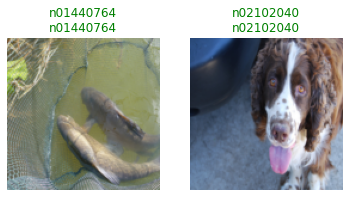

In [17]:
learn_overfit.show_results()

In [19]:
preds, targs = learn_overfit.get_preds()

In [23]:
preds

tensor([[1.2325e-06, 1.0000e+00],
        [6.2116e-01, 3.7884e-01]])

In [24]:
targs

TensorCategory([1, 0])